### Sistema de Recomendación

In [1]:
# Importar librerías:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import geopandas as gpd
from apyori import apriori
from collections import Counter
from wordcloud import WordCloud 
from dateutil.parser import parse 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (8, 6), 'figure.dpi': 120})
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Cargar dataset
data = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
data. head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Elimino filas sin países
data = data.loc[(data['Country'] != "Unspecified")] 
# Calculo las ventas totatles
data['venta_total'] = data.Quantity * data.UnitPrice
# Convertir la columna "fecha_hora" a formato de fecha y hora
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Separar la fecha y los minutos/segundos en columnas separadas
data['Date'] = data['InvoiceDate'].dt.date
data['minutos_segundos'] = data['InvoiceDate'].dt.time
# Elimino la columna (que no usaré) InvoiceDate:
data = data.drop(['InvoiceDate'], axis=1)
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,venta_total,Date,minutos_segundos
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010-12-01,08:26:00


## Gráficos

<function matplotlib.pyplot.show(close=None, block=None)>

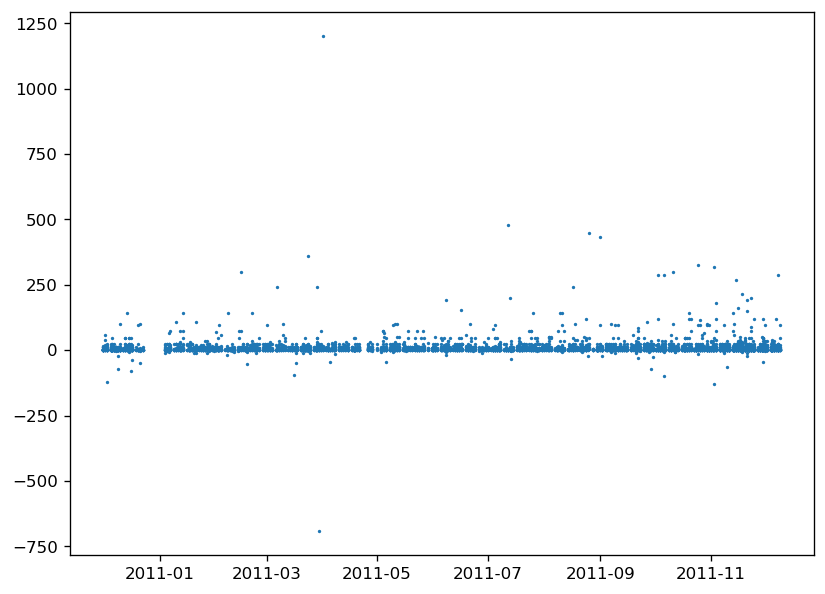

In [19]:
dataShort = data[::100]
plt.scatter(dataShort["Date"], dataShort["Quantity"] , s=1)
plt.show

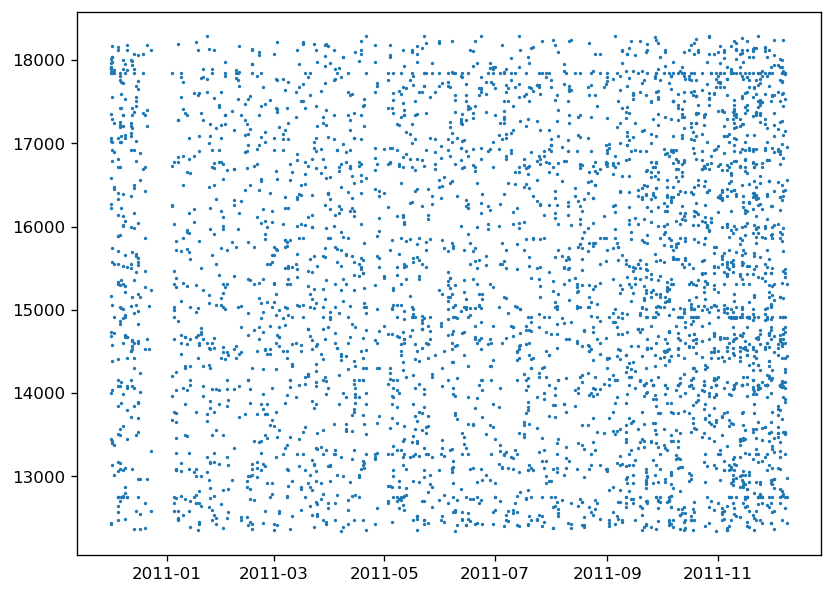

In [20]:
plt.scatter(dataShort["Date"], dataShort["CustomerID"], s=1)

<AxesSubplot:>

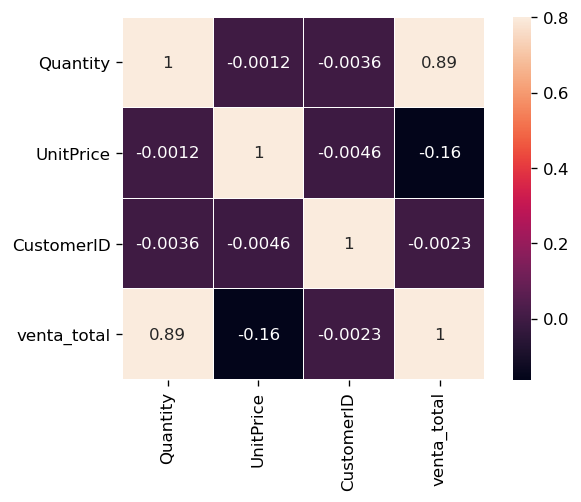

In [17]:
# Mapa de correlaciones
corr = data.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, vmax=.8, linewidths=0.01, square=True,annot=True)

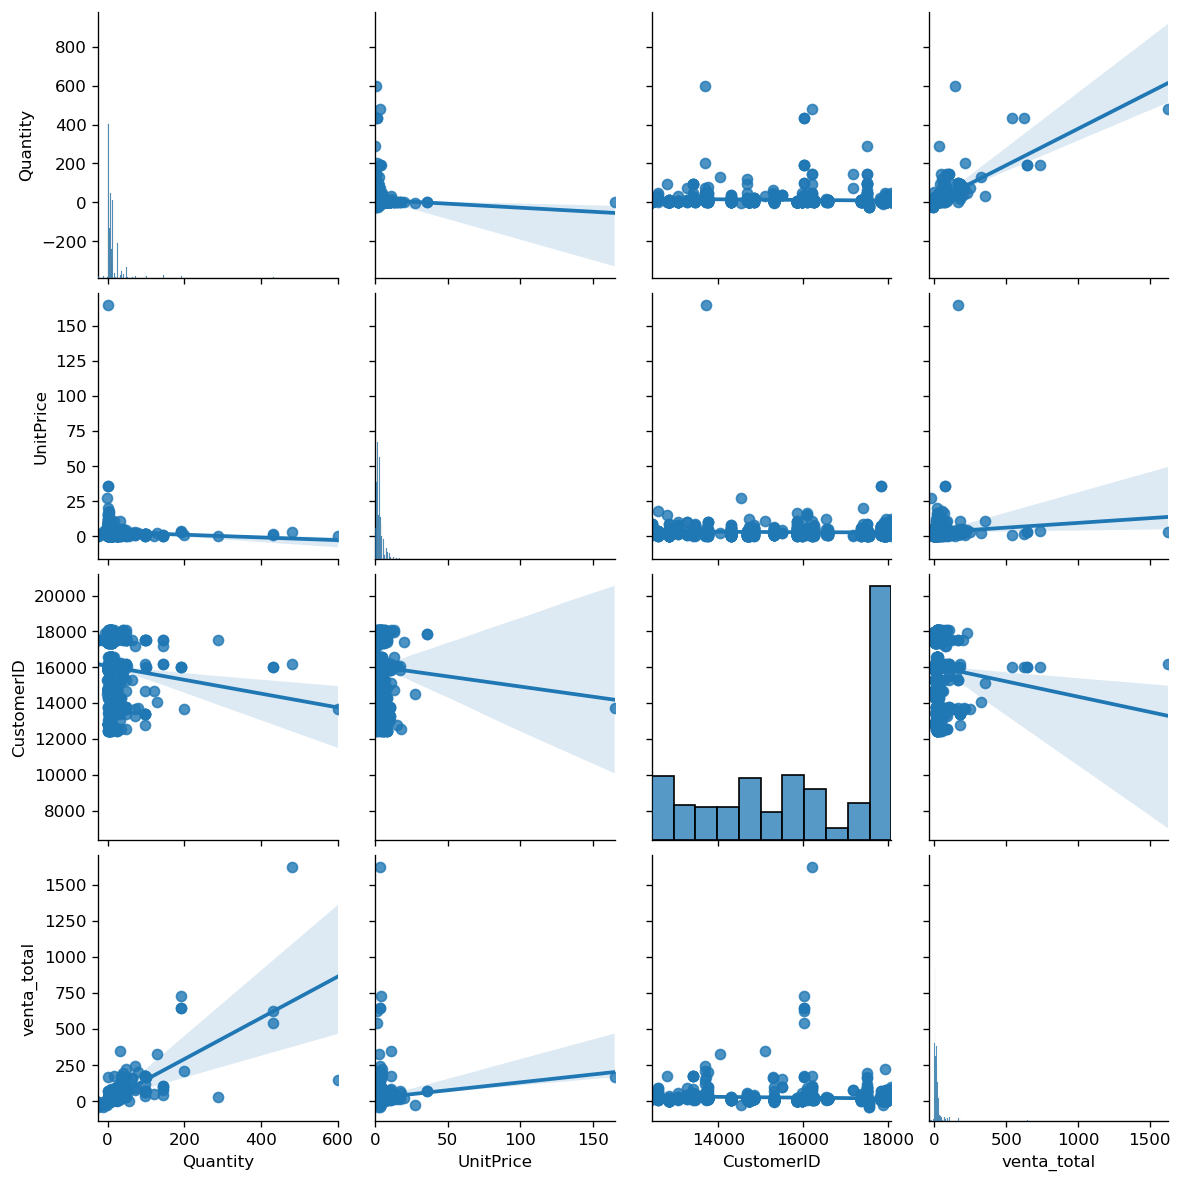

In [21]:
# Seaborn o PairGrid:
sns.pairplot(data[:1000], kind="reg")
plt.show()

In [4]:
vtas_totales_paises = data.groupby("Country", group_keys=False, as_index=False).sum('venta_total')
vtas_totales_paises = vtas_totales_paises.sort_values('venta_total',ascending=False)
vtas_totales_paises["logVentaTotal"] = np.log10(vtas_totales_paises["venta_total"])
vtas_totales_paises.head(2)

,Country,Quantity,UnitPrice,CustomerID,venta_total,logVentaTotal
36,United Kingdom,4263829,2.245715e+06,5.626433e+09,8.187806e+06,6.913168
24,Netherlands,200128,6.492550e+03,3.419054e+07,2.846615e+05,5.454329
10,EIRE,142637,4.844719e+04,1.103917e+08,2.632768e+05,5.420413


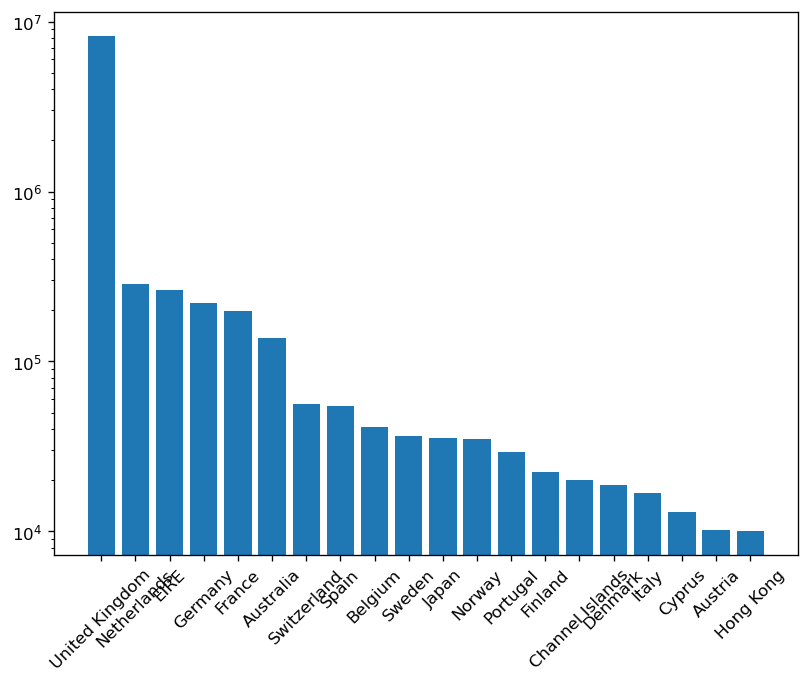

In [13]:
# Reducir para mostrar los 20 primeros
vtas_totales_paises_ = vtas_totales_paises[:20]
# Crear la gráfica de barras
plt.bar(vtas_totales_paises_.Country, vtas_totales_paises_['venta_total'])
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

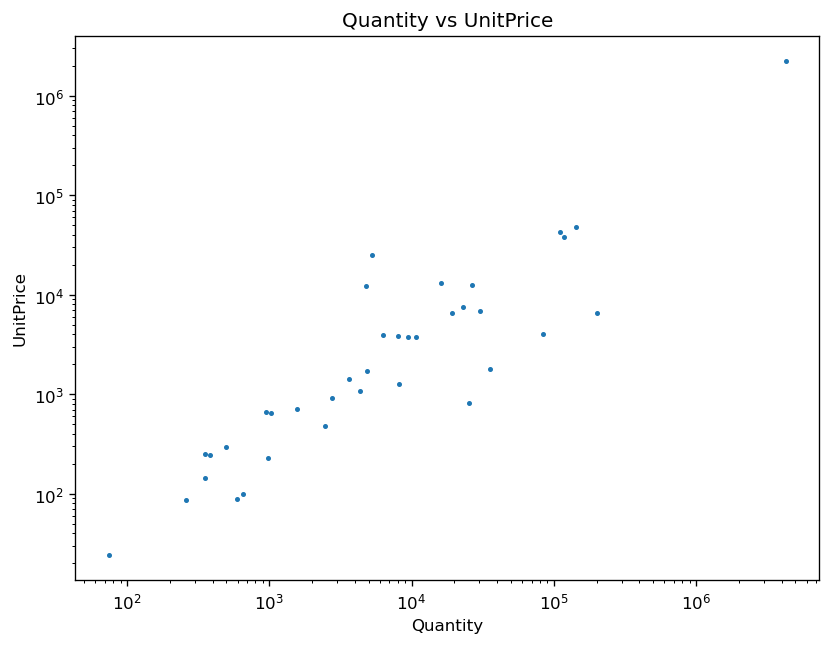

In [14]:
# Gráfica de dispersión (scatter) de Quantity vs UnitPrice 
plt.scatter(vtas_totales_paises['Quantity'], vtas_totales_paises['UnitPrice'], s=4)
plt.title("Quantity vs UnitPrice")
plt.xlabel("Quantity")
plt.ylabel("UnitPrice")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [15]:
titles=''.join(str(data.Description)).lower()
titles

"0          white hanging heart t-light holder\n1                         white metal lantern\n2              cream cupid hearts coat hanger\n3         knitted union flag hot water bottle\n4              red woolly hottie white heart.\n                         ...                 \n541904            pack of 20 spaceboy napkins\n541905           children's apron dolly girl \n541906          childrens cutlery dolly girl \n541907        childrens cutlery circus parade\n541908          baking set 9 piece retrospot \nname: description, length: 541463, dtype: object"

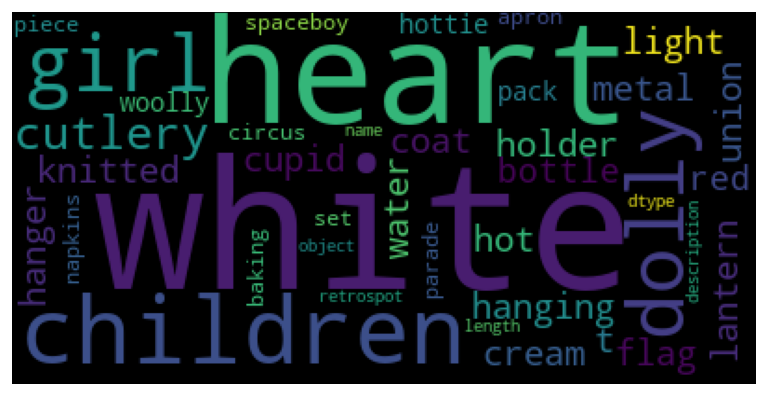

In [16]:
plt.figure(figsize=(8,6))
wordcloud = WordCloud(collocations=True, max_words=500 ).generate(titles)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

2. Construir un mapa que muestre número de compras totales por país y otro con número de compras relativas (per capita) por país.

In [22]:
# Lee los datos de los límites de los países
paises_geo_pandas = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Listado completo: pd.set_option('display.max_rows', 200)
paises_geo_pandas.name.sort_values

<bound method Series.sort_values of 0                          Fiji
1                      Tanzania
2                     W. Sahara
3                        Canada
4      United States of America
                 ...           
172                      Serbia
173                  Montenegro
174                      Kosovo
175         Trinidad and Tobago
176                    S. Sudan
Name: name, Length: 177, dtype: object>

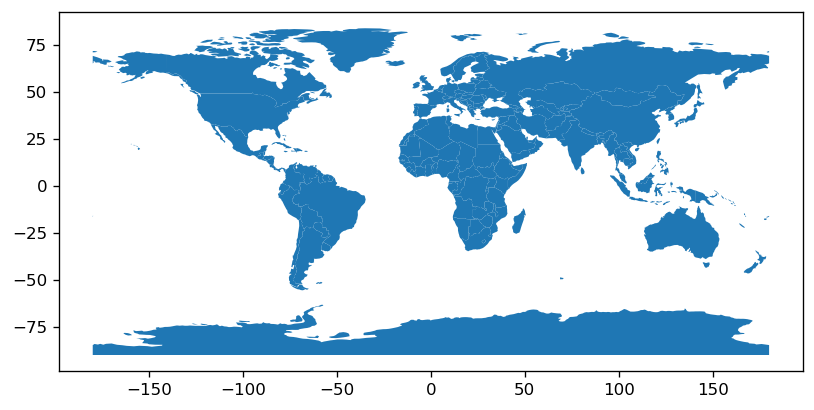

In [38]:
# Verificar si coincide los nombre de países del data frame con los del geopandas
#paises_geo_pandas.loc[paises_geo_pandas["name"]=="Iceland"]
# Crea una figura y un eje
fig, ax = plt.subplots(figsize=(8, 6))
# Dibuja los países en el mapa
paises_geo_pandas.plot(ax=ax)
# Muestra el mapa
plt.show()   

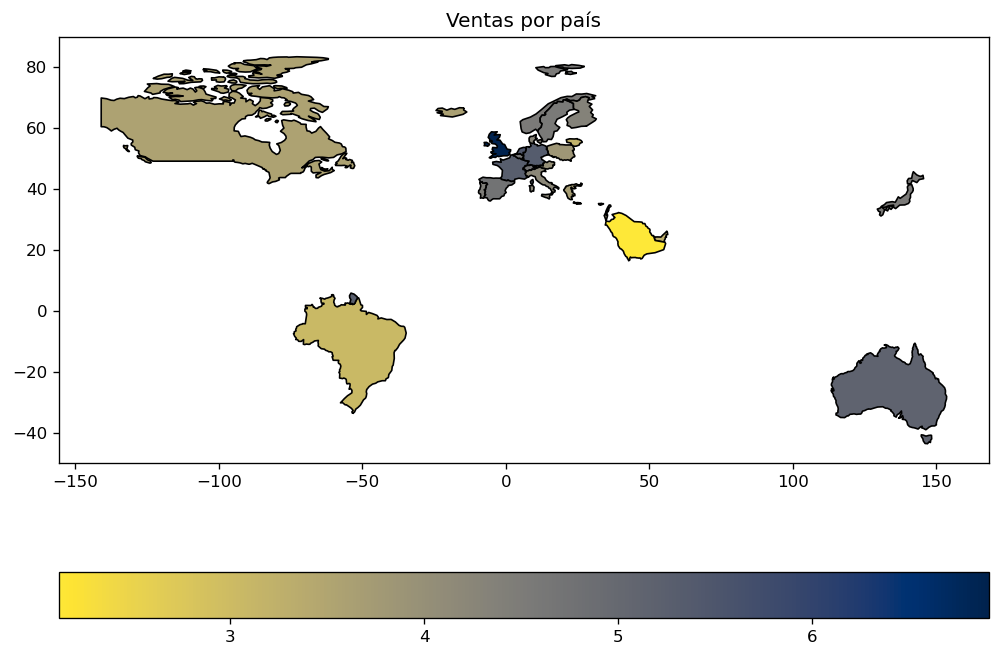

In [25]:
# Unir los datos de los países con los datos de ventas por país
data_merge = paises_geo_pandas.merge(vtas_totales_paises, left_on='name', right_on='Country')
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 8))
# Dibujar los países en el mapa y colorearlos según las ventas
data_merge.plot(ax=ax, column='logVentaTotal', cmap='cividis_r', linewidth=0.99, edgecolor='black', legend=True, legend_kwds={'orientation': "horizontal"})
# Añadir un título al mapa
ax.set_title('Ventas por país')    
#plt.yscale('log')
plt.show()

3. Analizar los horarios y calendarios de compra, mediante histogramas y estacionalidad.

In [37]:
# horas = pd.date_range(start=data['minutos_segundos'].min(),end=data['minutos_segundos'].max())
# dfHoras = pd.DataFrame(['minutos_segundos: Horas'])
horario_vta_totales = data.groupby("minutos_segundos", group_keys=False, as_index=False).sum('venta_total')
horario_vta_totales = horario_vta_totales.sort_values('venta_total',ascending=False)
horario_vta_totales_ = horario_vta_totales.minutos_segundos[::10]
horario_vta_totales_2 = horario_vta_totales[::100]
horario_vta_totales_2

,minutos_segundos,Quantity,UnitPrice,CustomerID,venta_total
112,09:15:00,85388,978.90,4587619.0,175237.89
479,15:22:00,12889,7431.53,12529446.0,24947.37
229,11:12:00,12395,3279.38,12165062.0,19260.41
396,13:59:00,8895,2193.13,11536767.0,15526.87
333,12:56:00,10205,13466.60,15847565.0,11523.53
530,16:13:00,3886,6686.04,11151119.0,5667.04
40,08:03:00,949,219.60,887721.0,1928.06
759,20:05:00,505,22.40,550250.0,240.66


In [ ]:
#Graficar minutos_segundos
#plt.bar(horario_vta_totales_2.minutos_segundos, horario_vta_totales_2['venta_total'])
#plt.xticks(rotation=45)
#plt.show()

In [28]:
# Calendario de ventas:
calendario_cant_vta = data.groupby(['Date'], group_keys=False, as_index=False).sum('Quantity')
calendario_cant_vta[calendario_cant_vta['Quantity'] < 0]

,Date,Quantity,UnitPrice,CustomerID,venta_total
152,2011-06-14,-13752,6435.36,16007436.0,40211.93


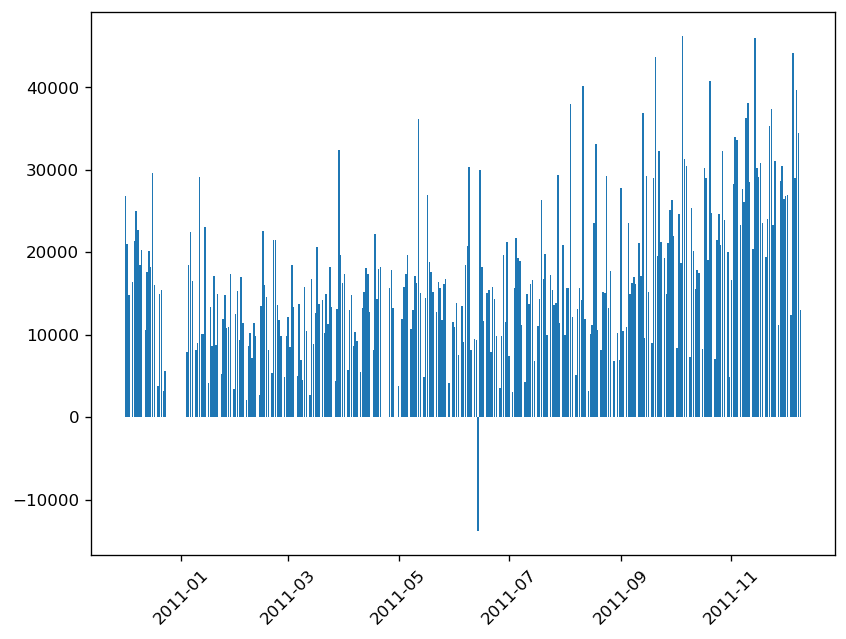

In [29]:
# Crear la gráfica de barras
plt.bar(calendario_cant_vta.Date, calendario_cant_vta['Quantity'])
#plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

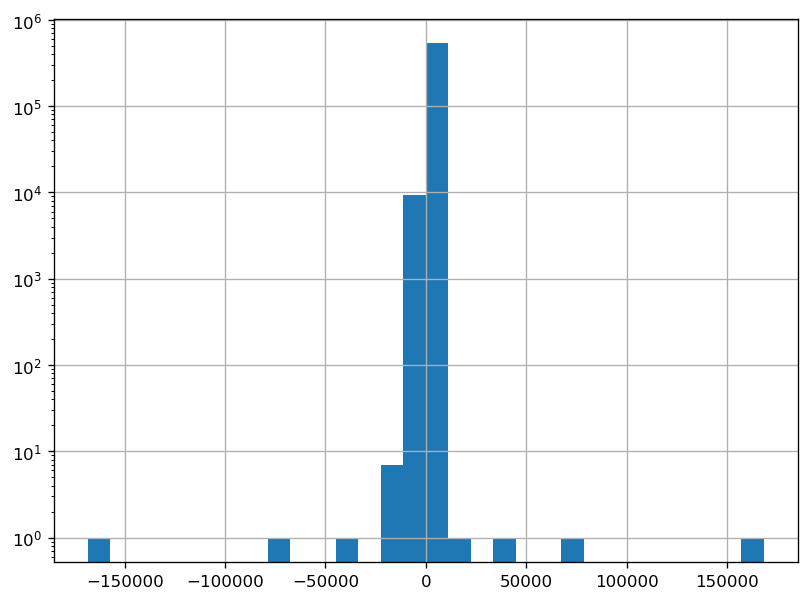

In [30]:
# Historama: Buscando bins más significativos (30 días = 1 mes)
data.venta_total.hist(bins=30)
plt.yscale('log')

4. Crear la **Customer-Item Matrix** mediante el método df.pivot_table

In [31]:
Customer_Item = pd.pivot_table(data, values='Quantity', index=['CustomerID'], columns=['StockCode'], aggfunc=np.sum)
Customer_Item.fillna(value=0, inplace=True)
Customer_Item.head(2)

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


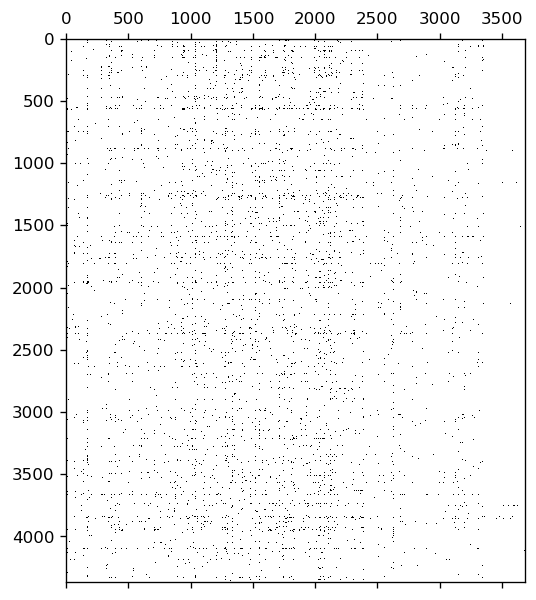

In [32]:
# Matriz para verificar queno todos los valores son NaN
plt.spy(Customer_Item)
plt.show()

5. Crear la **User to User Similarity Matrix** mediante la **distancia del coseno** con la librería sklearn

In [33]:
userUser = pd.DataFrame(cosine_similarity(Customer_Item))
userUser.head(2)

,0,1,2,3,4,5,6,7,8,9,...,4358,4359,4360,4361,4362,4363,4364,4365,4366,4367
0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
1,0.0,1.0,0.148879,0.02075,0.014435,0.034833,0.0,0.023478,0.506252,0.186107,...,0.0,0.0,0.40706,-0.001245,0.015133,0.037236,0.0,0.011921,0.07451,0.108942


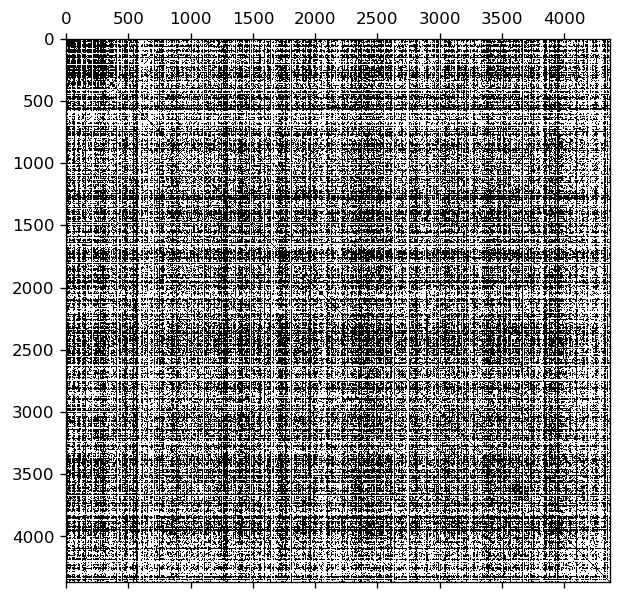

In [34]:
# Calculando la cantidad de usuarios. Matriz de user vs user:
userUser.shape
plt.spy(userUser)
plt.show()

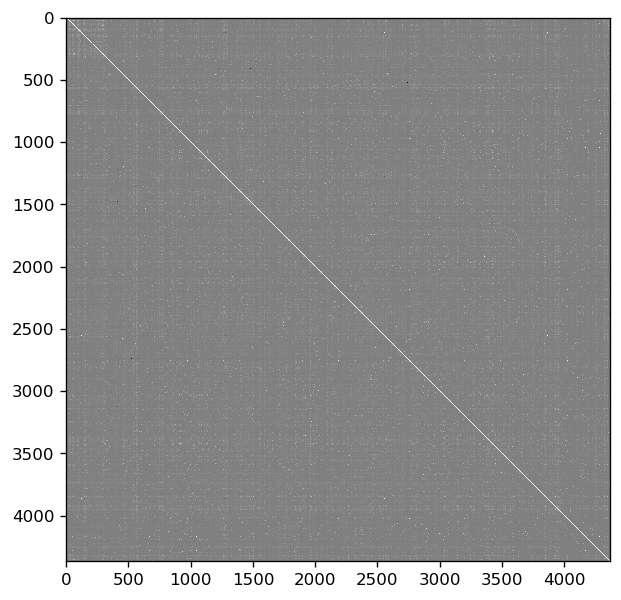

In [35]:
# Graficar matriz densa
plt.imshow(userUser, cmap='gray', interpolation='nearest')
plt.show()

6. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por usuario**.

In [18]:
userUser.columns = Customer_Item.index
userUser.index = Customer_Item.index
userUser.head(2)

CustomerID,12346.0,12347.0,12348.0,12349.0,12350.0,12352.0,12353.0,12354.0,12355.0,12356.0,...,18273.0,18274.0,18276.0,18277.0,18278.0,18280.0,18281.0,18282.0,18283.0,18287.0
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
12347.0,0.0,1.0,0.148879,0.02075,0.014435,0.034833,0.0,0.023478,0.506252,0.186107,...,0.0,0.0,0.40706,-0.001245,0.015133,0.037236,0.0,0.011921,0.07451,0.108942


In [36]:
userUser.iloc[1]

0       0.000000
1       1.000000
2       0.148879
3       0.020750
4       0.014435
          ...   
4363    0.037236
4364    0.000000
4365    0.011921
4366    0.074510
4367    0.108942
Name: 1, Length: 4368, dtype: float64

In [20]:
filtrado = userUser.iloc[1]
ranking = filtrado.sort_values(ascending = True)
ranking

CustomerID
14205.0   -0.072934
16742.0   -0.064460
17820.0   -0.062680
16428.0   -0.061159
14483.0   -0.004053
             ...   
12355.0    0.506252
14257.0    0.532188
12674.0    0.540213
14326.0    0.552321
12347.0    1.000000
Name: 12347.0, Length: 4368, dtype: float64

In [21]:
similares = ranking[(ranking > 0) & (ranking < 1)]
similares

CustomerID
13868.0    0.000025
18109.0    0.000046
14530.0    0.000067
13435.0    0.000115
15602.0    0.000123
             ...   
12355.0    0.506252
14257.0    0.532188
12674.0    0.540213
14326.0    0.552321
12347.0    1.000000
Name: 12347.0, Length: 3014, dtype: float64

In [22]:
Customer_Item.loc[list(similares.index)]

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
13868.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14530.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13435.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15602.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14257.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12674.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


In [23]:
all = Customer_Item.loc[list(similares.index)].sum()
all.sort_values(ascending = False).head(10)

StockCode
22197     43581.0
84077     39199.0
85099B    37004.0
21212     32359.0
84879     31926.0
85123A    27305.0
23084     27094.0
22492     25880.0
21977     23940.0
22616     21838.0
dtype: float64

7. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por producto** creando previamente la **Item to Item Similarity Matrix**.

In [38]:
ItemUser = pd.pivot_table(data, values='Quantity', index=['CustomerID'], columns=['Description'], aggfunc=np.sum)
ItemUser.fillna(value=0, inplace=True)
ItemUser.head(2)
# Buscar el cliente de posición: 12346.0

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
Item_Item = pd.DataFrame(cosine_similarity(ItemUser))
Item_Item.head(2)

,0,1,2,3,4,5,6,7,8,9,...,4358,4359,4360,4361,4362,4363,4364,4365,4366,4367
0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,1.0,0.148879,0.02075,0.014435,0.034833,0.0,0.022843,0.506252,0.186107,...,0.0,0.0,0.40706,-0.001245,0.015133,0.037236,0.0,0.011921,0.075245,0.108942


In [ ]:
# filtrado_item_item = Item_Item.iloc[12347.0]
# ranking_item_item = filtrado_item_item.sort_values(ascending = False)
# similares_item_item = ranking_item_item[(ranking_item_item > 0) & (ranking_item_item < 1)]
# print(similares_item_item.sort_values(ascending = False).head(10))

8. Obtener las 10 recomendaciones de tipo **basado en contenido** utilizando métricas de texto (Levenshtein o vectorización TF-IDF)

In [31]:
# Lista stopwords en inglés
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "something", "doesn", "even", "article", "behind", "much", "towards", "next", "since", "upon", "a", "s", "the", "to", "and", "in", "of", "is", "you", "for", "on", "it", "my", "that", "with", "be", "this", "at", "me", "was", "like", "so", "but", "just", "have", "are", "he", "from", "all", "not", "if", "can", "we", "your", "as", "one", "by", "out", "up", "will", "when", "about", "new", "what", "an", "get", "they", "his", "now", "has", "do", "love", "or", "don", "no", "who", "good", "her", "more", "know", "see", "how", "there", "day", "she", "time", "go", "think", "would", "lol", "people", "got", "re", "today", "only", "some", "movie", "back", "great", "going", "over", "world", "had", "our", "want", "watching", "best", "why", "really", "him", "life", "still", "make", "ll", "last", "first", "been", "right", "its", "should", "us", "too", "games", "after", "into", "big", "top", "before", "news", "video", "case", "court", "team", "does", "bang", "watch", "off", "white", "times", "turns", "man", "press", "heart", "free", "three", "black", "clubs", "home", "city", "teen", "shortly", "flight", "left", "match", "girls", "did", "done", "cannot", "again", "become", "never", "found", "better", "than", "other", "which", "even", "also", "same", "these", "though", "both", "their", "most", "much", "very", "any", "take", "almost", "may", "ever", "while", "made", "own", "where", "here", "view", "using", "during", "along", "through", "seen", "used", "year", "says", "long", "years", "old", "could", "pm", "ago", "week", "full", "next", "find", "live", "minute", "high", "need", "things", "site", "down", "look", "were", "say", "said", "search", "minutes", "inside", "rights", "reserved", "com", "post", "against", "two", "ahead", "least", "latest", "under", "then", "sees", "way", "being", "beyond", "part", "near", "daily", "photo", "making", "am", "read", "th", "around", "keep", "behind", "makes", "takes", "since", "them", "those", "wants", "move", "gets", "another", "saying", "doesn", "without", "every", "getting", "once", "might", "away", "put", "come", "didn", "many", "himself", "hasn", "such", "well", "because", "something", "use", "until", "wrong", "each", "below", "sure", "try", "must", "went", "between", "set", "however", "including", "became", "known", "text", "fig", "worth", "exactly", "enough", "quite", "aren", "across", "according", "within", "few", "lot", "among", "little", "doing", "yet", "per", "various", "whether", "further", "onto", "currently", "fast", "above", "otherwise", "although", "unlike", "together", "latestly", "aforementioned", "online", "information", "email", "copyright", "hours", "please", "english", "language", "click", "help", "privacy", "contact", "terms", "page", "policy", "account", "share", "service", "address", "work", "media", "follow", "blog", "money", "show", "reply", "add", "sign", "link", "posted", "content", "stay", "use", "users", "app", "website", "support", "via", "real", "web", "ad", "send", "download", "data", "the", "of", "and", "a", "in", "to", "it", "is", "was", "to", "i", "for", "you", "he", "be", "with", "on", "that", "by", "at", "are", "not", "this", "but", "s", "they", "his", "from", "had", "she", "which", "or", "we", "an", "were", "that", "been", "have", "their", "has", "would", "what", "will", "there", "if", "can", "all", "her", "as", "who", "have", "do", "that", "one", "said", "them", "some", "could", "him", "into", "its", "then", "two", "when", "up", "time", "my", "out", "so", "did", "about", "your", "now", "me", "no", "more", "other", "just", "these", "also", "people", "any", "first", "only", "new", "may", "very", "should", "as", "like", "her", "than", "as", "how", "well", "way", "our", "as", "between", "years", "er", "many", "those", "there", "ve", "being", "because", "based", "million", "different", "number", "provide", "access", "country", "end", "available", "report", "open", "days", "already", "working", "called", "receive", "process", "create", "able", "power", "change", "experience", "important", "told", "second", "current", "major", "order", "example", "level", "key", "neither", "direct", "nor", "directly", "indirectly", "mentioned", "disclaimer", "caused", "purposed", "details", "non", "vs", "built", "offs", "feel", "third", "solution", "user", "existing", "capable", "less", "instead", "whereas"]

In [32]:
# Extraemos las palabras  
contador = CountVectorizer() 
vectorizador = TfidfVectorizer(stop_words = stopwords)  
vectorizador

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', 'your', 'yours', 'yourself',
                            'yourselves', 'he', 'him', 'his', 'himself', 'she',
                            'her', 'hers', 'herself', 'it', 'its', 'itself',
                            'they', 'them', 'their', 'theirs', 'themselves',
                            'what', ...])

In [33]:
# Crear una matriz dispersa
cantidades = contador.fit_transform(ItemUser.columns)
valores = vectorizador.fit_transform(ItemUser.columns)
# print ("Vector de cantidades", cantidades)
# print ("Vector de valores", valores)

In [34]:
# Generate matrix of word vectors
tfidf_matrix = vectorizador.fit_transform(ItemUser.columns)
tfidf_matrix.shape

(3896, 1946)

In [35]:
tokens = vectorizador.get_feature_names()
tokens

['10',
 '11',
 '12',
 '120cm',
 '125g',
 '15',
 '15c',
 '15cm',
 '16',
 '16x16cm',
 '17080',
 '18pc',
 '20',
 '200',
 '20light',
 '21',
 '23',
 '24',
 '250g',
 '25w',
 '25x24x12cm',
 '30',
 '30cm',
 '30cmx30cm',
 '34x20cm',
 '35',
 '36',
 '3d',
 '40',
 '40cm',
 '40x40cm',
 '42',
 '45cm',
 '45x30cm',
 '45x45cm',
 '50',
 '500g',
 '50cm',
 '5g',
 '60',
 '60cm',
 '60x40cm',
 '65cmx65cm',
 '6pc',
 '70',
 '72',
 '75',
 '78',
 '8m',
 'a4',
 'a5',
 'a6',
 'a7',
 'abc',
 'abstract',
 'acapulco',
 'acrylic',
 'ade',
 'adult',
 'advent',
 'afghan',
 'aged',
 'ahoy',
 'aid',
 'air',
 'airline',
 'airmail',
 'alarm',
 'album',
 'allium',
 'alphabet',
 'alpine',
 'aluminium',
 'amber',
 'amelie',
 'amethyst',
 'anemone',
 'angel',
 'angels',
 'animal',
 'animals',
 'ant',
 'antique',
 'antoienett',
 'antoinette',
 'aperitif',
 'apothecary',
 'apple',
 'apples',
 'apron',
 'aqua',
 'area',
 'army',
 'art',
 'articulated',
 'artificial',
 'artiifcial',
 'ashtray',
 'ass',
 'assorted',
 'asst',
 'asstd

In [36]:
# 3.- Le paso una recomendacion
recomendacion = "PACK OF 20 SPACEBOY NAPKINS"
recomendacion

'PACK OF 20 SPACEBOY NAPKINS'

In [37]:
preguntaVector = vectorizador.transform([recomendacion])
preguntaVector

<1x1946 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [38]:
# print(preguntaVector)
def vector2df(vector, tokens):
    dfPregunta = pd.DataFrame()
    # Obtener la frecuencia de cada token en la pregunta
    frecuencias = np.array(vector.sum(axis=0))[0]
    # Imprimir los tokens y sus frecuencias
    # La función zip(tokens, frecuencias) combina las listas tokens y frecuencias para formar una secuencia de tuplas
    for token, frecuencia in zip(tokens, frecuencias):
        if frecuencia > 0:
            # print(token, frecuencia)
            dfPregunta.loc[token, "frecuencia"] = frecuencia
    dfPregunta = dfPregunta.sort_values("frecuencia", ascending=False)
    return dfPregunta
vector2df(preguntaVector, tokens)

,frecuencia
napkins,0.567461
20,0.541842
spaceboy,0.465064
pack,0.410013


In [39]:
coseno_similares = cosine_similarity(preguntaVector, tfidf_matrix)
# Obtener el índice de los 10 mayores números de una lista de los productos que más se parecen 
mejores_resultados = np.argsort(coseno_similares)[0]
mejores_resultados = np.flip(mejores_resultados)[:100] # inverse rearrange on numpy
mejores_resultados

array([2263, 2228, 2260, 2261, 2262, 3009, 3120, 3119, 2955, 2227, 2252,
       2278, 3142, 3335, 3670, 3324,   38, 3329, 3330, 3325,  272,  710,
       3326, 3327,  706, 2053, 1774, 1956,    9, 3008,  697, 1799, 3331,
       2583, 3470, 3332,   30,  714,  692, 2945, 3328, 3032,  699, 3037,
       2964,   12,  231, 2063, 3334, 1980, 1986, 1985,   48, 2259, 2245,
       2248, 2250, 1987, 2256, 2242, 2251, 2235, 1988, 2247, 3333, 2238,
       2266, 2241, 2254, 2271, 2272, 2258, 2244, 2231, 2232, 2257, 2273,
       2267, 2237, 2282, 1989, 2243, 2269, 2268, 2236, 2279, 2230, 2229,
       2249, 2239, 2274, 2255, 2277, 2253, 2234, 2280, 2246, 2275,  959,
       2264], dtype=int64)

In [40]:
for i in mejores_resultados:
    print(i)
    print(coseno_similares[0][i])
    # Obtener el vector de características del documento de interés
    vector_documento = tfidf_matrix[i]
    print(vector2df(vector_documento, tokens)[:5])
print(recomendacion)
print("\n")

2263
1.0
          frecuencia
napkins     0.567461
20          0.541842
spaceboy    0.465064
pack        0.410013
2228
0.7503521226566541
         frecuencia
napkins    0.543303
20         0.518776
pack       0.392558
paper      0.381599
rose       0.368746
2260
0.732726872134
         frecuencia
napkins    0.530542
20         0.506590
pantry     0.445701
pack       0.383337
design     0.341021
2261
0.7182832715906836
         frecuencia
napkins    0.520084
apples     0.501827
20         0.496604
pack       0.375781
red        0.299760
2262
0.7134075188697957
         frecuencia
napkins    0.516553
20         0.493233
skull      0.467934
pack       0.373230
paper      0.362810
3009
0.670567482977377
           frecuencia
napkins      0.618125
20           0.590219
christmas    0.383649
vintage      0.349823
3120
0.6092764919437899
            frecuencia
napkins       0.561627
20            0.536272
strawberry    0.491306
paper         0.394469
3119
0.6060703697276784
           frecuen

9. Realizar un **market basket analysis** para detectar **bundles** (packs) de productos. Algoritmos de clusterización como K-means podrían detectar los bundles más frecuentes.

In [96]:
X = data.groupby(by="InvoiceNo").sum()

,Quantity,UnitPrice,CustomerID,venta_total
InvoiceNo,,,,
536365,40,27.37,124950.0,139.12
536366,12,3.70,35700.0,22.20
536367,83,58.24,156564.0,278.73
536368,15,19.10,52188.0,70.05
536369,3,5.95,13047.0,17.85
...,...,...,...,...
C581484,-80995,2.08,16446.0,-168469.60
C581490,-23,2.78,28794.0,-32.53
C581499,-1,224.69,15498.0,-224.69


In [85]:
X = data[["Quantity", "UnitPrice"]]

In [86]:
# Crear un objeto KMeans con 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)

In [97]:
# Aplicar el algoritmo K-means para que el modelo busque  los centroides mediante convergencia
kmeans.fit(X) 

KMeans(n_clusters=2, random_state=0)

In [98]:
y_kmeans = kmeans.predict(X) # el modelo determina el cluster correspondiente al dato según su distancia a los centroides
y_kmeans

array([0, 0, 0, ..., 0, 0, 0])

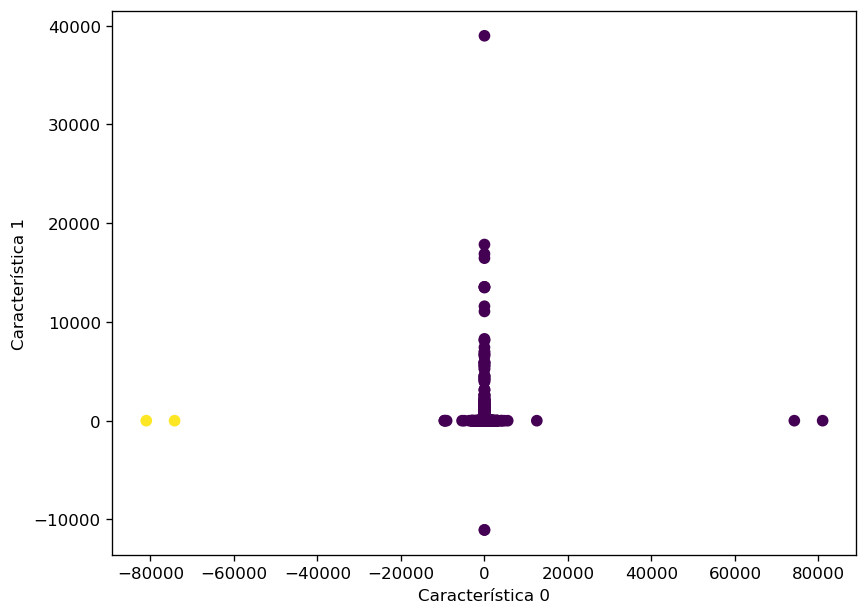

In [99]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, cmap='viridis')
plt.xlabel('Característica 0')
plt.ylabel('Característica 1')
plt.show()

In [92]:
# Obtener los centroides de los clusters
centroids = kmeans.cluster_centers_
# Obtener las etiquetas de los clusters para cada transacción
labels = kmeans.labels_
# Imprimir los resultados con n_clusters=3
print("Centroides:\n", centroids)
print("Etiquetas:\n", labels)

Centroides:
 [[ 9.84070875e+00  4.61269943e+00]
 [-7.76050000e+04  1.56000000e+00]]
Etiquetas:
 [0 0 0 ... 0 0 0]
